In [1]:
# ---------------------------------------------------------------------------
# 1) Imports
# ---------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.stats import norm

In [2]:
# Import your modules
import os
os.chdir('/Users/jingyizhang/Desktop/MA4288O/deephedging/MA4288O-Project')

# Import your own modules:
from market.heston import HestonModel
# For the neural net strategies:
from utils.networks import RecurrentHedgeModel, SimpleHedgeModel
# For training loops & loss:
from optimizer.hedge_train import DeepHedgeCVaRTrainer  # or whatever class name you used
# from optimizer.loss_functions import cvar_loss  # if needed for direct calls
from payoff.european_option import european_call_payoff  # <-- IMPORTANT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# ---------------------------------------------------------------------------
# 2) Optional: Model Hedge (e.g. Black-Scholes) function
# ---------------------------------------------------------------------------
def black_scholes_call_price_delta(S0, K, T, sigma):
    """
    For r=0. Returns (price, delta).
    """
    d1 = (np.log(S0/K) + 0.5*sigma**2*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)

    price = S0*norm.cdf(d1) - K*norm.cdf(d2)
    delta = norm.cdf(d1)
    return price, delta

def compute_model_hedge_pnl(q, Z, delta_const, S_paths):
    """
    frictionless PnL = q - Z + delta_const * sum_{k=0}^{n-1} [S_{k+1}-S_k].
    """
    S_diff = S_paths[:,1:] - S_paths[:,:-1]  # shape (n_paths, n_steps)
    gains = delta_const * np.sum(S_diff, axis=1)
    pnl = q - Z + gains
    return pnl

In [4]:
def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

In [5]:
# ----------------------------------------------------------------------------
# 3) Simulation Setup
# ----------------------------------------------------------------------------
num_paths = 200_000
num_steps = 30
T = 30/365  # 30 days

heston = HestonModel(
    s0=100.0,
    v0=0.04,
    kappa=1.5,
    theta=0.04,
    xi=0.5,
    rho=-0.7,
    r=0.0,
    dt=T/num_steps,
    seed=1234
)

S_paths_np, V_paths_np = heston.simulate_paths(n_paths=num_paths, n_steps=num_steps)
print("Simulated S_paths shape:", S_paths_np.shape)

K = 100.0
Z_np = european_call_payoff(S_paths_np, K=K)
print("Payoff shape:", Z_np.shape)

# Convert to torch
S_torch = torch.from_numpy(S_paths_np).float().to(device)
Z_torch = torch.from_numpy(Z_np).float().to(device)

# These tensors will be used later in training

Simulated S_paths shape: (200000, 31)
Payoff shape: (200000,)


In [6]:
# ----------------------------------------------------------------------------
# 4) Model Hedge
# ----------------------------------------------------------------------------
sigma_guess = 0.2
q_bs, delta_bs = black_scholes_call_price_delta(S0=100.0, K=K, T=T, sigma=sigma_guess)

# Convert q_bs to tensor for consistency in training
p0_init = torch.tensor([q_bs], dtype=torch.float32, device=S_torch.device)

model_pnl = compute_model_hedge_pnl(q_bs, Z_np, delta_bs, S_paths_np)
print("Model Hedge Stats:")
print("  mean PnL =", model_pnl.mean())
print("  std PnL  =", model_pnl.std())

Model Hedge Stats:
  mean PnL = 0.04533853082149925
  std PnL  = 1.7444771163482315


In [7]:
import time

In [8]:
# ----------------------------------------------------------------------------
# 5) Train Recurrent Hedge under CVaR alpha=0.5
# ----------------------------------------------------------------------------
import torch

# Ensure tensors are on the correct device
S_torch = S_torch.to(device)
Z_torch = Z_torch.to(device)

# Define CVaR risk level
alpha = 0.5  

# Ensure num_steps is defined
num_steps = S_torch.shape[1] - 1  

# Initialize Recurrent Hedge Model (now using shared architecture)
recurrent_model = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)

# Use the updated DeepHedgeCVaRTrainer
trainer_rec = DeepHedgeCVaRTrainer(
    model=recurrent_model, 
    loss_function="cvar", 
    alpha=alpha
)

start = time.time()

# Train the model using p0_init from Black-Scholes
p0_rec = trainer_rec.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=p0_init,  # <- tensor from earlier
    n_epochs=5,
    batch_size=4096
)
training_time_recurrent = time.time() - start

print(f"Recurrent Hedge Price p0_rec = {p0_rec:.4f}")

# Evaluate model performance (no gradient computation needed)
with torch.no_grad():
    deltas_rec = recurrent_model(S_torch)
    Sdiff = S_torch[:, 1:] - S_torch[:, :-1]  
    gains_rec = torch.sum(deltas_rec * Sdiff, dim=1)
    pnl_rec = (trainer_rec.p0 - Z_torch + gains_rec).cpu().numpy()


Epoch 1/5 | Loss: 1.2393 | p0: 2.2872
Epoch 2/5 | Loss: 1.1890 | p0: 2.2872
Epoch 3/5 | Loss: 1.2100 | p0: 2.2872
Epoch 4/5 | Loss: 1.1728 | p0: 2.2872
Epoch 5/5 | Loss: 1.1545 | p0: 2.2872
Recurrent Hedge Price p0_rec = 2.2872


In [9]:
# Define a higher risk aversion level (alpha = 0.99 for 99%-CVaR)
alpha_99 = 0.99  

# Initialize and train the model under 99%-CVaR
recurrent_model_99 = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)
trainer_rec_99 = DeepHedgeCVaRTrainer(model=recurrent_model_99, loss_function="cvar", alpha=alpha_99)

start = time.time()

p0_rec_99 = trainer_rec_99.train(
    S_tensor=S_torch,
    Z_tensor=Z_torch,
    p0_init=q_bs,  
    n_epochs=5,
    batch_size=4096
)

training_time_recurrent_99 = time.time() - start

print(f"99%-CVaR Hedge Price p0_rec_99 = {p0_rec_99:.4f}")

# Compute PnL for 99%-CVaR hedge
with torch.no_grad():
    deltas_rec_99 = recurrent_model_99(S_torch)
    Sdiff_99 = S_torch[:, 1:] - S_torch[:, :-1]
    gains_rec_99 = torch.sum(deltas_rec_99 * Sdiff_99, dim=1)
    pnl_rec_99 = (trainer_rec_99.p0 - Z_torch + gains_rec_99).cpu().numpy()


Epoch 1/5 | Loss: 117.2907 | p0: 2.2872
Epoch 2/5 | Loss: 153.5916 | p0: 2.2872
Epoch 3/5 | Loss: 290.8821 | p0: 2.2872
Epoch 4/5 | Loss: 79.0352 | p0: 2.2872
Epoch 5/5 | Loss: 112.8866 | p0: 2.2872
99%-CVaR Hedge Price p0_rec_99 = 2.2872


In [11]:
import pandas as pd

In [12]:
# ---------------------------------------------------------------------------
# 6) Metrics Collection
# ---------------------------------------------------------------------------
results = {
    "0.5 CVaR": {
        "pnl": pnl_rec,
        "price": p0_rec,
        "time": training_time_recurrent
    },
    "0.99 CVaR": {
        "pnl": pnl_rec_99,
        "price": p0_rec_99,
        "time": training_time_recurrent_99
    },
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl, alpha=0.5)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}",
        "Time (s)": f"{res.get('time', float('nan')):.2f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 Hedging Strategy Comparison:\n")
print(summary_df)


🔍 Hedging Strategy Comparison:

          Mean PnL Std PnL    MSHE CVaR (0.5) Price (q) Time (s)
0.5 CVaR    0.0450  1.4915  2.2267    -1.1545    2.2872    12.77
0.99 CVaR   0.0469  2.2803  5.2020    -1.4223    2.2872    13.30


In [13]:
def plot_side_by_side_hist(pnl1, pnl2, label1="Strategy A", label2="Strategy B",
                           bins=20, x_range=(-10, 10), title=None, save_path=None):
    """
    Plot side-by-side histograms for two PnL distributions with aligned bins.
    
    Args:
        pnl1, pnl2: numpy arrays of PnL values.
        label1, label2: labels for the two strategies.
        bins: number of histogram bins (default is 20 for wider bins).
        x_range: tuple, (min, max) for histogram x-axis.
        title: custom plot title. If None, generates one automatically.
        save_path: optional file path to save the plot.
    """
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10, 6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')

    plt.xlabel("Terminal Hedging PnL", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.title(title or f"Side-by-side PnL Histogram: {label1} vs. {label2}")
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


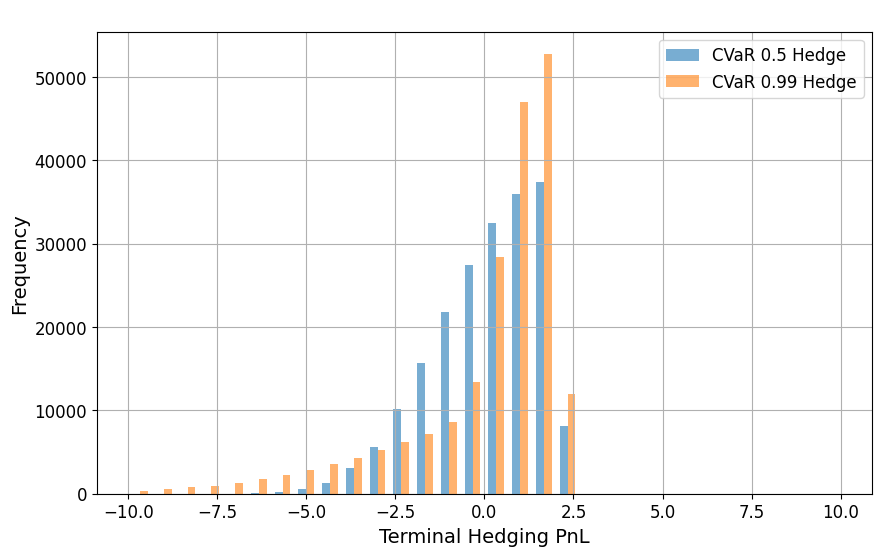

In [14]:
plot_side_by_side_hist(
    pnl1=pnl_rec,
    pnl2=pnl_rec_99,
    label1="CVaR 0.5 Hedge",
    label2="CVaR 0.99 Hedge",
    bins=30,
    x_range=(-10, 10),
    title=" "
)

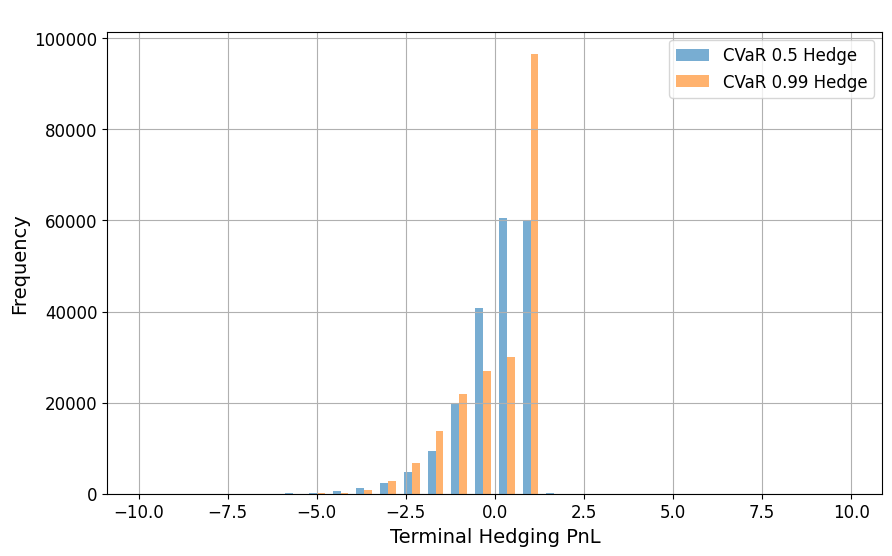

In [23]:
pnl_rec_99_scaled = pnl_rec_99 / np.std(pnl_rec_99)
pnl_rec_scaled = pnl_rec / np.std(pnl_rec)
plot_side_by_side_hist(
    pnl1=pnl_rec_scaled,
    pnl2=pnl_rec_99_scaled,
    label1="CVaR 0.5 Hedge",
    label2="CVaR 0.99 Hedge",
    bins=30,
    x_range=(-10, 10),
    title=" "
)

In [12]:
# 4.3.1: Compare CVaR(0.99) vs CVaR(0.5) for Recurrent Hedge

import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.networks import RecurrentHedgeModel
from optimizer.hedge_train import DeepHedgeCVaRTrainer

def empirical_cvar(pnl, alpha=0.5):
    pnl_sorted = np.sort(pnl)
    idx = int(len(pnl) * alpha)
    return np.mean(pnl_sorted[:idx])

# Ensure tensors are on the correct device
S_torch = S_torch.to(device)
Z_torch = Z_torch.to(device)

num_steps = S_torch.shape[1] - 1

# ----------------------------------------------------------------------------
# Train under alpha = 0.5
# ----------------------------------------------------------------------------
rec_model_05 = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)
trainer_05 = DeepHedgeCVaRTrainer(alpha=0.5)
trainer_05.model = rec_model_05
trainer_05.lr = 1e-3
trainer_05.n_epochs = 5

start = time.time()
q_05, pnl_05, _, _ = trainer_05.train(S_torch, Z_torch)
time_05 = time.time() - start

# ----------------------------------------------------------------------------
# Train under alpha = 0.99
# ----------------------------------------------------------------------------
rec_model_99 = RecurrentHedgeModel(steps=num_steps, hidden_dim=32).to(device)
trainer_99 = DeepHedgeCVaRTrainer(alpha=0.99)
trainer_99.model = rec_model_99
trainer_99.lr = 1e-3
trainer_99.n_epochs = 5

start = time.time()
q_99, pnl_99, _, _ = trainer_99.train(S_torch, Z_torch)
time_99 = time.time() - start

# ----------------------------------------------------------------------------
# Metrics
# ----------------------------------------------------------------------------
results = {
    "0.5-CVaR Hedge": {
        "pnl": pnl_05,
        "price": q_05,
        "time": time_05
    },
    "0.99-CVaR Hedge": {
        "pnl": pnl_99,
        "price": q_99,
        "time": time_99
    }
}

for name, res in results.items():
    pnl = res["pnl"]
    res["mean"] = np.mean(pnl)
    res["std"] = np.std(pnl)
    res["mshe"] = np.mean(pnl**2)
    res["cvar"] = empirical_cvar(pnl, alpha=0.5)

summary_df = pd.DataFrame({
    name: {
        "Mean PnL": f"{res['mean']:.4f}",
        "Std PnL": f"{res['std']:.4f}",
        "MSHE": f"{res['mshe']:.4f}",
        "CVaR (0.5)": f"{res['cvar']:.4f}",
        "Price (q)": f"{res['price']:.4f}",
        "Time (s)": f"{res['time']:.2f}"
    }
    for name, res in results.items()
}).T

print("\n🔍 CVaR Hedge Comparison Metrics:\n")
print(summary_df)

# ----------------------------------------------------------------------------
# PnL Histogram
# ----------------------------------------------------------------------------
def plot_cvar_hist(pnl1, pnl2, label1="CVaR 0.5", label2="CVaR 0.99", bins=60, x_range=(-10, 10)):
    counts1, edges = np.histogram(pnl1, bins=bins, range=x_range)
    counts2, _     = np.histogram(pnl2, bins=edges)

    centers = 0.5 * (edges[:-1] + edges[1:])
    width   = (edges[1] - edges[0]) / 3.0

    plt.figure(figsize=(10,6))
    plt.bar(centers - width/2, counts1, width=width, alpha=0.6, label=label1, color='tab:blue')
    plt.bar(centers + width/2, counts2, width=width, alpha=0.6, label=label2, color='tab:orange')
    plt.xlabel("Terminal Hedging PnL")
    plt.ylabel("Frequency")
    plt.title("PnL Distribution: CVaR 0.5 vs CVaR 0.99")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cvar_hist(pnl_05, pnl_99)


TypeError: __init__() missing 1 required positional argument: 'model'